# Генеративная нейронная сеть

Ваша основная задача: научиться генерировать стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). 

В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [1]:
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from IPython.display import clear_output

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

#### 1. Загрузка данных.

In [6]:
!curl -O https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
100  256k  100  256k    0     0  82600      0  0:00:03  0:00:03 --:--:-- 82683


In [4]:
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])

#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [9]:
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("All fine!")

text_encoded = [token_to_idx[x] for x in text]

All fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете обратиться к следующим ссылкам:
* Статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Пример генерации по поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. 

Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. 
Вы можете использовать его при обучении модели.

In [10]:
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))

Пример батча:

In [11]:
next(generate_chunk())

array([[83, 56, 53, ..., 45,  1, 56],
       [83, 64, 55, ..., 58, 53, 57],
       [83, 45, 76, ..., 58, 53, 63],
       ...,
       [83, 45, 49, ..., 50, 49, 53],
       [83, 58, 50, ..., 47, 52, 76],
       [83, 47,  1, ...,  1, 52, 45]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [16]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm.notebook import tqdm
import torch.optim as optim

In [13]:
epochs = 2000
seq_length = 100
hidden_size = 100
vocab_size = num_tokens
learning_rate = 1e-3
n_layers =1

$vs$ - vocabulary size

$hs$ - hidden size

$x_t\in R^{vs}$

$h_t \in R^{hs}$

$V \in R^{vc*hs}$

$W \in R^{hs*hs}$

$U \in R^{hs*vs}$

$b \in R^{hs}$

$c \in R^{vs}$


$h^{(t)}(t)=tanh(b+W*h^{(t-1)}+U * x^{(t)})$

$y^{(t)}=softmax(c+V*h^{(t)})$

In [18]:
class RNN:
    def __init__(self, hidden_size, vocab_size, seq_length, learning_rate, U=None, V=None, W=None, b=None, c=None):
        """
        :param hidden_size:
        :param vocab_size: count characters in dictionary
        :param seq_length: length of sequence of characters
        :param learning_rate: learning rate
        :param U: [hidden_size, vocab_size]
        :param W: [hidden_size, hidden_size]
        :param V: [vocab_size, hidden_size]
        :param b: [hidden_size, 1]
        :param c: [vocab_size, 1]
        """
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.seq_length = seq_length
        self.learning_rate = learning_rate
        self.U = U if U is not None else np.random.uniform(-np.sqrt(1./vocab_size), np.sqrt(1./vocab_size), (hidden_size, vocab_size)) * 0.01
        self.V = V if V is not None else np.random.uniform(-np.sqrt(1./hidden_size), np.sqrt(1./hidden_size), (vocab_size, hidden_size)) * 0.01
        self.W = W if W is not None else np.random.uniform(-np.sqrt(1./hidden_size), np.sqrt(1./hidden_size), (hidden_size, hidden_size)) * 0.01
        self.b = b if b is not None else np.zeros((hidden_size, 1))
        self.c = U if U is not None else np.zeros((vocab_size, 1))
        self.mU, self.mW, self.mV = np.zeros_like(self.U), np.zeros_like(self.W), np.zeros_like(self.V)
        self.mb, self.mc = np.zeros_like(self.b), np.zeros_like(self.c)
        self._smooth_loss = -np.log(1./vocab_size) * seq_length

    def forward(self, inputs, h_prev):
        """
        :param inputs: [seq_len]
        :param h_prev: [hidden_size]
        :return xs: {seq_len, vocab_size}
        :return hs: {seq_len + 1, hidden_size}
        :return ycap: {seq_len, vocab_size}
        """
        xs, hs, os, ycap = {}, {}, {}, {}
        hs[-1] = np.copy(h_prev)
        for t in np.arange(len(inputs)): # iterate throw batch
            xs[t] = np.zeros((self.vocab_size, 1))
            xs[t][inputs[t]] = 1 # one-hot vector
            hs[t] = np.tanh(self.b + self.W @ hs[t-1] + self.U @ xs[t]) # hidden state
            os[t] = self.c + self.V @ hs[t]
            ycap[t] = self.softmax(os[t]) # probs
        return xs, hs, ycap

    def softmax(self, x, temperature=1):
        """
        Compute the softmax with temperature of vector x in a numerically stable way
        :param x: [seq_len]
        :param temperature: float
        :return softmax(x): [seq_len]
        """
        if temperature != 1:
            x /= temperature
        p = np.exp(x - np.max(x))
        return p / np.sum(p)

    def loss(self, ps, targets, eps=1e-8):
        """
        Calculate cross-entropy loss
        :param ps: [seq_length, vocab_size]
        :param targets: [seq_length]
        :return loss: float
        """
        loss = - np.sum([np.log(ps[i][y]+ eps) for i, y in enumerate(targets)], axis=0)
        return loss / self.seq_length

    def backward(self, xs, hs, ycap, targets):
        """
        :param xs: {seq_length, vocab_size}
        :param hs: {seq_length + 1, hidden_size}
        :param ycap: {seq_length, vocab_size}
        :param targets: [seq_length]
        :return dU: [hidden_size, vocab_size]
        :return dW: [hidden_size, hidden_size]
        :return dV: [vocab_size, hidden_size]
        :return db: [hidden_size, 1]
        :return dc: [vocab_size, 1]
        """
        dU, dW, dV = np.zeros_like(self.U), np.zeros_like(self.W), np.zeros_like(self.V)
        db, dc =  np.zeros_like(self.b), np.zeros_like(self.c)
        dh_next = np.zeros_like(hs[0])
        for t in reversed(np.arange(self.seq_length)):
            dy = np.copy(ycap[t])
            dy[targets[t]] -= 1
            dV += dy @ hs[t].T
            dc += dy
            dh = self.V.T @ dy + dh_next
            dh_rec = (1 - hs[t-1]**2) * dh
            db += dh_rec
            dU += dh_rec @ xs[t].T
            dW += dh_rec @ hs[t-1].T
            dh_next = self.W.T @ dh_rec
        for dparam in [dU, dW, dV, db, dc]:
            np.clip(dparam, -5, 5, out=dparam)
        return dU, dW, dV, db, dc


    def update_model(self, dU, dW, dV, db, dc, ps, targets):
        """
        Updates parameters of model: self.U, self.W, self.V, self.b, self.c
        param <- param - self.lr * grad(param)
        :param dU: [hidden_size, vocab_size]
        :param dW: [hidden_size, hidden_size]
        :param dV: [vocab_size, hidden_size]
        :param db: [hidden_size, 1]
        :param dc: [vocab_size, 1]
        """
        loss = self.loss(ps, targets)
        self._smooth_loss = self._smooth_loss * 0.999 + loss * 0.001
        for param, dparam, mem in zip([self.U, self.W, self.V, self.b, self.c],
                                      [dU, dW, dV, db, dc],
                                      [self.mU, self.mW, self.mV, self.mb, self.mc]):
            mem += dparam * dparam
            param -= self.learning_rate * dparam / np.sqrt(mem + 1e-8)
        return loss

    def train(self, epochs, generate_chunk):
        loss_history = []
        for epoch in tqdm(np.arange(epochs)):
            chunk = next(generate_chunk())
            batch_size = chunk.shape[0]
            inputs = chunk[:, :-1]
            targets = chunk[:, 1:]
            h_prev = np.zeros((self.hidden_size, 1))
            for batch in np.arange(batch_size):
                xs, hs, ycap = self.forward(inputs[batch], h_prev)
                ps = np.array([ycap[t] for t in np.arange(self.seq_length)])
                dU, dW, dV, db, dc = self.backward(xs, hs, ycap, targets[batch])
                loss = self.update_model(dU, dW, dV, db, dc, ps, targets[batch])
                loss_history.append(loss)
            if epoch % 10 == 0:
                print(f'Epoch {epoch}/{epochs}, Loss: {loss[-1]}')
        return loss_history


    def predict(self, token_to_idx, idx_to_token, start, n):
        """
        :param data_reader: [hidden_size, vocab_size]
        :param start: start sequence of text (string)
        :param n: length of predicted text (int)
        :return txt: [hidden_size, 1]
        """
        x = np.zeros((self.vocab_size, 1))
        chars = [ch for ch in start]
        ixes = []
        for i in np.arange(len(chars)):
            ix = token_to_idx[chars[i]]
            x[ix] = 1
            ixes.append(ix)
        h = np.zeros((self.hidden_size, 1))
        for t in np.arange(n):
            h = np.tanh(self.U @ x + self.W @ h + self.b)
            y = self.V @ h + self.c
            p = self.softmax(y)
            ix = np.random.choice(np.arange(self.vocab_size), p=p.ravel())
            x[ix] = 1
            ixes.append(ix)
        txt = ''.join(idx_to_token[i] for i in ixes)
        return txt

In [ ]:
rnn = RNN(hidden_size, vocab_size, seq_length, learning_rate)
loss_history = rnn.train(epochs, generate_chunk)

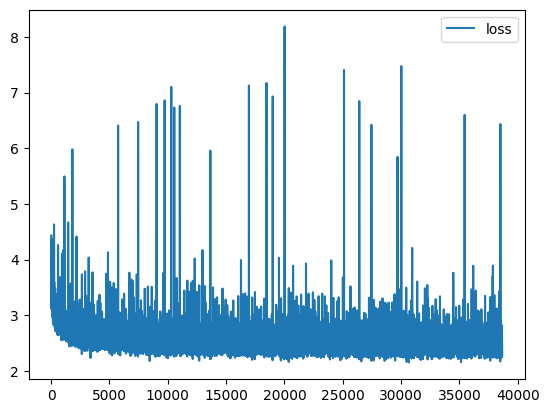

In [36]:
step = 100
epochs = range(0, len(loss_history['pde']), step)

plt.plot(epochs, loss_history[::step], label='loss')
plt.legend()

In [26]:
rnn.predict(token_to_idx, idx_to_token, ' мой дядя самых честных правил', n=500)

' мой дядя самых честных правилеооееоаыесаеееараюе?ет…ерсяььн ь  ,л  н  ,ь ,н,   ч     е  неанн и   ея    и  \nт\nе .     м      ;  ,        \n   \n   \n   \n      \n                  т \nн\n \n \n \n   нн \n\n   \n  \nт\n \n  ,\n \n\n             \n   \n   л     с н  х  \n   \n \n  \n \n\n              \n   \n ,\n  \n \n  \n    \n,       \n       \n    , \n\n,\n\n , \n      \n ,       \n\n   \n   \n          \n.   \n        \n    \n    \n  \n н  \n  жы, ,  !ь \n   \n \n  \n    \nн  \n\n\n  \n  \n  \n   \n   \n\n\n  \n\n          , \n\n ,       \n\n   \n   ,\n  \n    \n   ,   ,      \n\n,   \n  \n \n :\n  \n   '

In [13]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, dropout=0.5):
        super(VanillaRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.loss_history = None
        self.rnn = nn.GRU(input_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, hidden_size),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size)

    def train_model(self, epochs, batch_size, criterion, optimizer):
        self.train()
        loss_history = []
        for e in tqdm(np.arange(epochs), desc="Training Epochs"):
            hidden = self.init_hidden(batch_size)
            chunk = next(generate_chunk())
            inputs = torch.nn.functional.one_hot(torch.tensor(chunk[:, :-1]), num_classes=num_tokens).float()
            targets = torch.tensor(chunk[:,1:]).reshape(-1)
            optimizer.zero_grad()
            outputs, hiddens = self(inputs, hidden)
            outputs = outputs.view(-1, outputs.size(-1))
            targets = targets.view(-1)
            loss = criterion(outputs, targets)
            loss_history.append(loss.item())
            loss.backward()
            optimizer.step()
            if e % 100 == 0:
                print(f'Epoch [{e + 1}/{epochs}], Loss: {loss_history[-1]:.4f}')
        self.loss_history = loss_history

In [ ]:
model = VanillaRNN(input_size=vocab_size, hidden_size=hidden_size, output_size=vocab_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.train_model(epochs, batch_size, criterion, optimizer)

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [ ]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    #feed the seed phrase, if any

    # your code here

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [ ]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

<sos> мой дядя самых честных правилас;



xiv

но как потокой.



xii

«я свобред не словавран в скорей,
для с посвялесь мне моловой,
те ты,
перегиной в тям праздной
и привезут перваю вся вновся сквозь ти стала сблился,
и старый свимарной таня обратель любова не когда и нет волностье нежной
тишен,
перестоком.
«поже постаничив очествы
в и старько забаньем и заковенью,
ее своя моднать наводушта;
какой нет поли своем горозный и быле и, законно он ходушних недважный плая
с за стра.



xvii




xxvi

все 
